In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedGroupKFold
import wandb

import torch
from torch import nn
from torchvision import models
import torch.optim as optim

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Paths
root = '/media/latlab/MR/projects/kaggle-ubc-ocean'
data_dir = os.path.join(root, 'data')
results_dir = os.path.join(root, 'results')
train_csv = 'train.csv'
train_image_dir = os.path.join(data_dir, 'train_images')
train_thumbnail_dir = os.path.join(data_dir, 'train_thumbnails')
tile_set_name = 'train_tiles_2048_p25_test_v1'
tiles_dir = os.path.join(results_dir, tile_set_name)

# Load data
df = pd.read_csv(os.path.join(data_dir, train_csv))

In [54]:
import scipy

def split_crop(image, dir: str, th: int=0):
    if dir == 'h':
        labels, _ = scipy.ndimage.label(image.sum(axis=(0, 2)) > th)
    elif dir == 'v':
        labels, _ = scipy.ndimage.label(image.sum(axis=(1, 2)) > th)
    unique, counts = np.unique(labels, return_counts=True)
    counts = counts[unique!=0]
    unique = unique[unique!=0]
    larges_label = unique[np.argmax(counts)]
    if dir == 'h':
        image = image[:, labels==larges_label, :]
    elif dir == 'v':
        image = image[labels==larges_label, :, :]
    return image

def smart_crop(image):
    image = np.array(image)

    # Iterative split and crop
    image = split_crop(image, 'h')
    image = split_crop(image, 'v')
    image = split_crop(image, 'h')
    image = split_crop(image, 'v')

    black_bg = np.sum(image, axis=2) == 0
    image[black_bg, :] = 255

    return Image.fromarray(image)

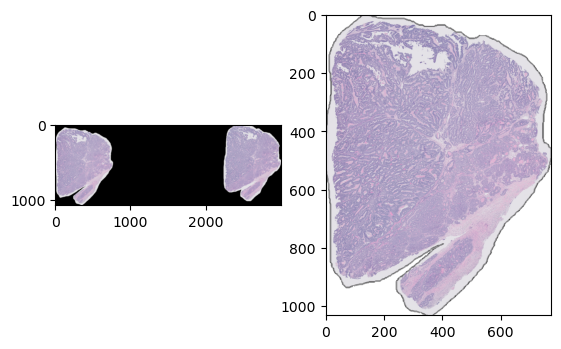

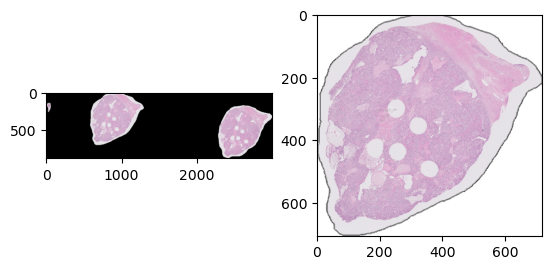

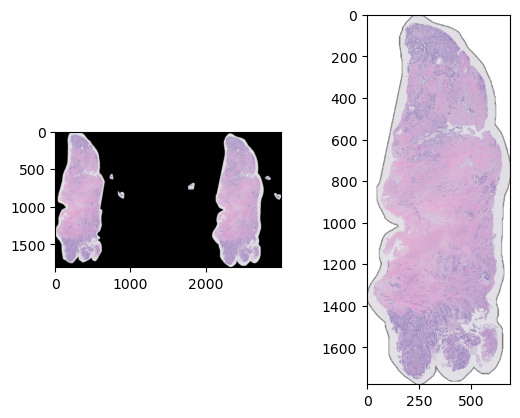

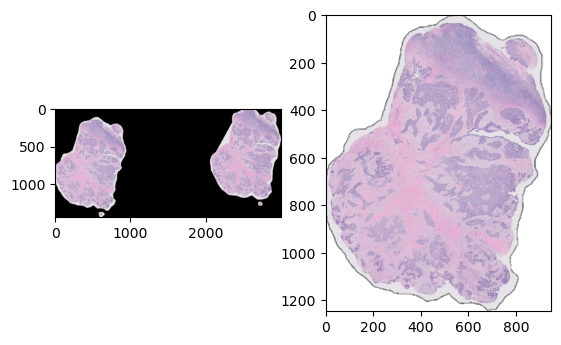

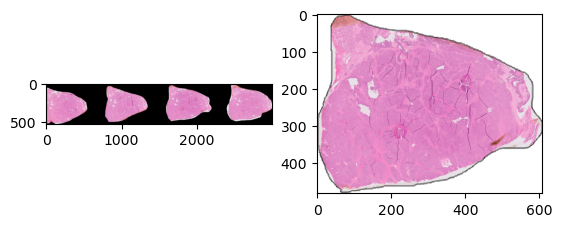

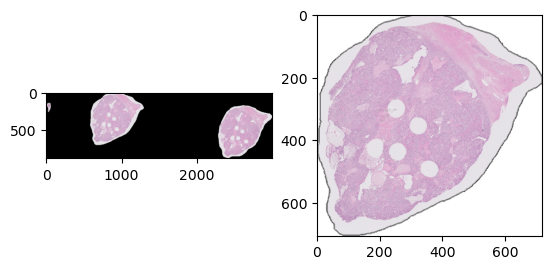

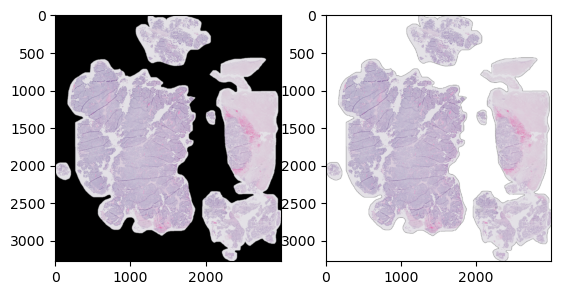

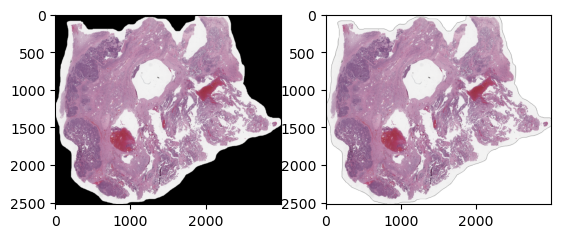

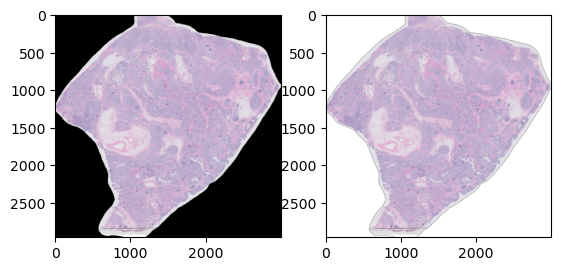

In [56]:
image_id_list = ['44804', '60685', '34845', '20858', '5251', '60685', '63289', '4', '66']

for image_id in image_id_list:
    image = Image.open(os.path.join(train_thumbnail_dir, image_id+'_thumbnail.png'))
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.subplot(1, 2, 2)
    plt.imshow(smart_crop(image))

In [ ]:
model = models.get_model('efficientnet_b0', weights='DEFAULT').to(device)
model.classifier

In [ ]:
model = models.get_model('vit_b_16', weights='DEFAULT').to(device)
model.heads.head

In [ ]:
model = models.get_model('resnet34', weights='DEFAULT').to(device)
model.fc